### Imports

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../kaggle_prediction_library/') 
import preprocess
import feature_engineering
import submission
from sklearn.model_selection import train_test_split

# from hyperopt import tpe, fmin, Trials
# import hyperopt.hp as hp

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_validate, train_test_split

import matplotlib.pyplot as plt

from yellowbrick.model_selection import ValidationCurve, LearningCurve



In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.feature_selection import chi2
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import brier_score_loss
from sklearn.neural_network import MLPClassifier



### Data set up

In [3]:
to_predict_mens = pd.read_csv("to_predict_mens.csv")

In [4]:
regular_season_results = pd.read_csv('../data/MRegularSeasonDetailedResults.csv')
detailed_tourney_results = pd.read_csv('../data/MNCAATourneyDetailedResults.csv')
rankings = pd.read_csv('../data/MMasseyOrdinals.csv')
seeds = pd.read_csv('../data/MNCAATourneySeeds.csv')

kp_rankings = pd.read_csv('../data/kenpom_pre_tourney_snapshot.csv')

regular_season_results_w = pd.read_csv('../data/WRegularSeasonDetailedResults.csv')
detailed_tourney_results_w = pd.read_csv('../data/WNCAATourneyDetailedResults.csv')
seeds_w = pd.read_csv('../data/WNCAATourneySeeds.csv')

# _538_df = pd.read_csv('../data/all_538.csv')

M538 = pd.read_csv('../data/M538.csv')
W538 = pd.read_csv('../data/W538.csv')

base = preprocess.PreProcess(detailed_tourney_results, regular_season_results).process()

base_w = preprocess.PreProcess(detailed_tourney_results_w, regular_season_results_w).process()
base = preprocess.PreProcess(detailed_tourney_results, regular_season_results).process()

tourney_games = base[base.TourneyGame == 1]
regular_season_games = base[base.TourneyGame == 0]

tourney_games_w = base_w[base_w.TourneyGame == 1]
regular_season_games_w = base_w[base_w.TourneyGame == 0]

In [5]:
sub = pd.read_csv('../data/SampleSubmission2023.csv')

mteams = pd.read_csv('../data/MTeams.csv')
wteams = pd.read_csv('../data/WTeams.csv')
to_predict=submission.SubmissionSetup(sub, tourney_games, tourney_games_w, mteams.copy()).setup()

to_predict_mens = to_predict[to_predict.Gender == 'M'].copy()
to_predict_womens = to_predict[to_predict.Gender == 'W'].copy()


In [6]:
aggregated, all_games = feature_engineering.Efficiency(games=regular_season_games, away_bonus=0).process(return_detailed=True)

In [7]:
all_games['game_num'] = all_games.groupby(['Season', 'Team1'])['DayNum'].rank(method='first')

In [8]:
tmp = all_games.pivot(index=["Team1", "Season"], columns=["game_num"], values=["adj_oe"]).reset_index()
tmp.columns = [str(x[0]) for x in tmp.columns[0:2]] + [str(x[0]) + str(int(float(x[1]))) for x in tmp.columns[2:]]
tmp = tmp.fillna(-1)

In [9]:
tmp2 = all_games.pivot(index=["Team1", "Season"], columns=["game_num"], values=["adj_de"]).reset_index()
tmp2.columns = [str(x[0]) for x in tmp2.columns[0:2]] + [str(x[0]) + str(int(float(x[1]))) for x in tmp2.columns[2:]]
tmp2 = tmp2.fillna(-1)

In [10]:
# Define a function that takes 36 inputs
def value_slide(row):

    col_values = list(row.values[2:])

    while True:
        if col_values[-1] == -1:
            val = col_values.pop()
            col_values.insert(0, val)
        else:
            break
        
    return col_values

# Apply the function to each row
tmp[['adj_oe1', 'adj_oe2', 'adj_oe3', 'adj_oe4',
       'adj_oe5', 'adj_oe6', 'adj_oe7', 'adj_oe8', 'adj_oe9', 'adj_oe10',
       'adj_oe11', 'adj_oe12', 'adj_oe13', 'adj_oe14', 'adj_oe15', 'adj_oe16',
       'adj_oe17', 'adj_oe18', 'adj_oe19', 'adj_oe20', 'adj_oe21', 'adj_oe22',
       'adj_oe23', 'adj_oe24', 'adj_oe25', 'adj_oe26', 'adj_oe27', 'adj_oe28',
       'adj_oe29', 'adj_oe30', 'adj_oe31', 'adj_oe32', 'adj_oe33', 'adj_oe34',
       'adj_oe35', 'adj_oe36']]= tmp.apply(value_slide, axis=1, result_type='expand')

tmp = tmp.rename(columns={"Team1": "TeamID"})


In [11]:
# tmp = tmp.replace({-1:np.nan})
# cols = [col for col in tmp.columns if 'adj' in col]
# tmp['avg_adj_oe'] = tmp[cols].mean(axis=1)
# for col in cols:
#     tmp[col] = tmp[col].fillna(tmp['avg_adj_oe'])

In [11]:
# Apply the function to each row
tmp2[['adj_de1', 'adj_de2', 'adj_de3', 'adj_de4',
       'adj_de5', 'adj_de6', 'adj_de7', 'adj_de8', 'adj_de9', 'adj_de10',
       'adj_de11', 'adj_de12', 'adj_de13', 'adj_de14', 'adj_de15', 'adj_de16',
       'adj_de17', 'adj_de18', 'adj_de19', 'adj_de20', 'adj_de21', 'adj_de22',
       'adj_de23', 'adj_de24', 'adj_de25', 'adj_de26', 'adj_de27', 'adj_de28',
       'adj_de29', 'adj_de30', 'adj_de31', 'adj_de32', 'adj_de33', 'adj_de34',
       'adj_de35', 'adj_de36']]= tmp2.apply(value_slide, axis=1, result_type='expand')

tmp2 = tmp2.rename(columns={"Team1": "TeamID"})

In [12]:
# tmp2 = tmp2.replace({-1:np.nan})
# cols = [col for col in tmp2.columns if 'adj' in col]
# tmp2['avg_adj_de'] = tmp2[cols].mean(axis=1)
# for col in cols:
#     tmp2[col] = tmp2[col].fillna(tmp2['avg_adj_de'])

In [13]:
class vector_features(feature_engineering.FeatureEng):
    
    def __init__(self,df):
        self.df=df
    
    def process(self):
        return self.df
    

In [14]:
to_predict_mens = vector_features(tmp).add(to_predict_mens)

In [15]:
to_predict_mens = vector_features(tmp2).add(to_predict_mens)

In [17]:
to_predict_mens = feature_engineering.TournamentSeed(tourney_seeds=seeds).add(to_predict_mens)


In [16]:
train = to_predict_mens[to_predict_mens.Season < 2017].copy()
test = to_predict_mens[to_predict_mens.Season >= 2017].copy()

features = [col for col in train if "adj" in col] #+ ['seed_diff']

target = 'Outcome'

train[target] = train[target].astype(int)
#train[features] = MinMaxScaler().fit_transform(train[features])



### Param Tuning

In [34]:
def get_best_params_from_grid_search(train, features, target, model, parameters, scoring, verbose=10):
    gs = GridSearchCV(estimator=model, param_grid=parameters, scoring=scoring, verbose=verbose)
    gs.fit(train[features], train[target])
    return gs.best_params_


In [35]:
model = MLPClassifier(max_iter=1000, random_state=23)

parameters = {'hidden_layer_sizes':[(100, 50, 25)],
              'learning_rate_init':[.0001, .0005, .001],
               'activation':['logistic', 'tanh', 'relu'],
               'alpha':[.0005, .0001, .001]
              }

best_params = get_best_params_from_grid_search(train, features, target, model, parameters, 
                                               scoring='neg_brier_score', verbose=15)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001
[CV 1/5; 1/27] END activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001;, score=-0.277 total time=  12.6s
[CV 2/5; 1/27] START activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 1/27] END activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001;, score=-0.267 total time=  12.9s
[CV 3/5; 1/27] START activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001
[CV 3/5; 1/27] END activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001;, score=-0.272 total time=  13.8s
[CV 4/5; 1/27] START activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 1/27] END activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001;, score=-0.300 total time=  12.6s
[CV 5/5; 1/27] START activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 1/27] END activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001;, score=-0.273 total time=  13.6s
[CV 1/5; 2/27] START activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005
[CV 1/5; 2/27] END activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005;, score=-0.182 total time=   1.2s
[CV 2/5; 2/27] START activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005
[CV 2/5; 2/27] END activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005;, score=-0.169 total time=   1.7s
[CV 3/5; 2/27] START activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005
[CV 3/5; 2/27] END activation=logistic, alpha=0.0005, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005;, score=-0.214 total time=   1.6s
[CV 4/5; 2/27] START activation=logistic, alpha=0.0005, hidd

/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 4/27] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001;, score=-0.256 total time=  13.0s
[CV 2/5; 4/27] START activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 4/27] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001;, score=-0.249 total time=  13.7s
[CV 3/5; 4/27] START activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 4/27] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001;, score=-0.286 total time=  13.9s
[CV 4/5; 4/27] START activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 4/27] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001;, score=-0.315 total time=  12.8s
[CV 5/5; 4/27] START activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 4/27] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001;, score=-0.245 total time=  12.7s
[CV 1/5; 5/27] START activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005
[CV 1/5; 5/27] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005;, score=-0.202 total time=   1.9s
[CV 2/5; 5/27] START activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005
[CV 2/5; 5/27] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005;, score=-0.199 total time=   2.3s
[CV 3/5; 5/27] START activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005
[CV 3/5; 5/27] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005;, score=-0.219 total time=   1.1s
[CV 4/5; 5/27] START activation=logistic, alpha=0.0001, hidd

/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 7/27] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001;, score=-0.257 total time=  13.7s
[CV 2/5; 7/27] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 7/27] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001;, score=-0.291 total time=  13.1s
[CV 3/5; 7/27] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 7/27] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001;, score=-0.276 total time=  12.1s
[CV 4/5; 7/27] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 7/27] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001;, score=-0.299 total time=  12.0s
[CV 5/5; 7/27] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 7/27] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0001;, score=-0.289 total time=  12.2s
[CV 1/5; 8/27] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005
[CV 1/5; 8/27] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005;, score=-0.206 total time=   1.7s
[CV 2/5; 8/27] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005
[CV 2/5; 8/27] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005;, score=-0.189 total time=   2.2s
[CV 3/5; 8/27] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005
[CV 3/5; 8/27] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.0005;, score=-0.215 total time=   1.6s
[CV 4/5; 8/27] START activation=logistic, alpha=0.001, hidden_layer

In [36]:
best_params

{'activation': 'logistic',
 'alpha': 0.0005,
 'hidden_layer_sizes': (100, 50, 25),
 'learning_rate_init': 0.0005}

In [22]:
best_params = {'activation': 'logistic',
 'alpha': 0.0001,
 'hidden_layer_sizes': (150,),
 'learning_rate_init': 0.0005}

### Learning Curve

In [142]:
def plot_learning_curve(train, target, features, model, scoring, xlabel, ylabel, title, yticks=None, sizes=np.linspace(0.1, 1.0, 20), cv=StratifiedKFold(n_splits=10), random_state=23):
    viz = LearningCurve(
        model, cv=cv, scoring=scoring, train_sizes=sizes, n_jobs=-1, random_state=random_state)
    viz.fit(train[features], train[target])
    viz.ax.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    if yticks:
        viz.ax.set_yticks(yticks)
    plt.show()

/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization

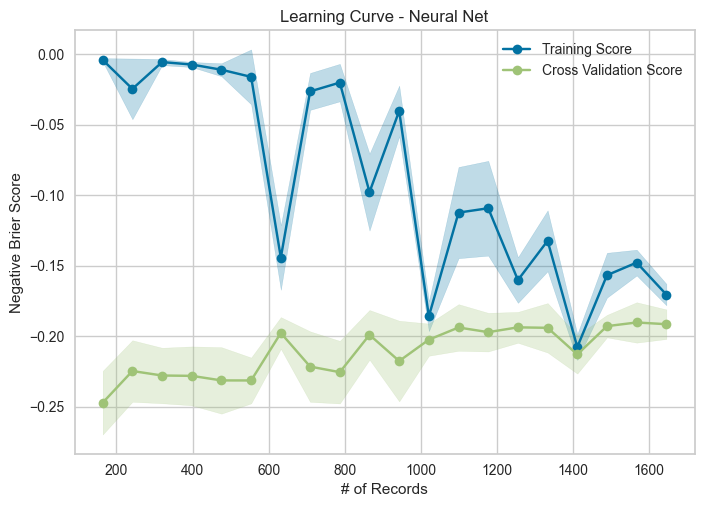

In [143]:
model = MLPClassifier(max_iter=1000, random_state=23, **best_params)

plot_learning_curve(train, 'Outcome', features, model, 
                    'neg_brier_score', 
                    "# of Records", 
                    "Negative Brier Score", 
                    "Learning Curve - Neural Net", 
                    yticks=None, 
                    sizes=np.linspace(0.1, 1.0, 20), 
                    cv=StratifiedKFold(n_splits=10), 
                    random_state=23)


### CV Scoring

In [17]:
def rolling_season_cv(model, train_input, features, label='Outcome', cv_start=2007):
    ''' returns estimate for model performance using shifted validation'''
    
    scores = []

    for n, season in enumerate(train_input.Season.unique()):
        
        if season >= cv_start:

            train = train_input[train_input.Season < season]
            test = train_input[train_input.Season == season]

            X_train = train[features]
            X_test = test[features]
            y_train = train[label]
            y_test = test[label]

            model.fit(X_train[features], y_train)
            y_prob = model.predict_proba(X_test[features])
            loss = brier_score_loss(y_test, y_prob[:,1])
            scores.append((season, loss))

    validation_df = pd.DataFrame(scores, columns = ['season', 'score']).sort_values(by = 'score')
    avg_validation_score = validation_df.score.mean()
    return avg_validation_score


In [27]:
# model = MLPClassifier(max_iter=1000, random_state=23, activation='tanh',
#  alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.005)
model = MLPClassifier(max_iter=1000, random_state=23, **best_params)
rolling_season_cv(model, train, features)

/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.20084677700144898

In [37]:
# model = MLPClassifier(max_iter=1000, random_state=23, activation='tanh',
#  alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.005)

model = MLPClassifier(max_iter=1000, random_state=23, hidden_layer_sizes=(100, 50, 25),
                      activation='logistic', alpha=0.0005, learning_rate_init=0.0005)

rolling_season_cv(model, train, features)


0.214876221413

In [ ]:
# can try testing out different cv methods
# for each year, build model with 5 seasons from past and 5 from future
# evaluate whether the future model does better (suggesting bias) or if it doesn't matter  

In [14]:
to_predict_mens.Season.unique()

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023])

In [ ]:
#2008 - 2017 have 5 seasons on both sides